# Evolutionary multiobjective optimization

LEAP currently directly supports one form of multiobjective optimization, NSGA-II, but there is intent to implement other common evolutionary multiobjective algorithms.

## Naive evolutionary multiobjective optimization

A naive approach to evolutionary multiobjective optimization would be to simply sum up the fitnesses, biased by a weight, as a final, single fitness, $f(x)$:

$f(x) = \sum \limits_{i=0}^n w_i f_i$

Where $f_i$ is the fitness for objective _i_.

However, there isn't very satisfying because we have to decide on $w_i$, which we usually don't know. A better approach would be to evolve solutions along a Pareto front where each solution on the front dominates other solutions.

## NSGA-II

The NSGA-II algorithm is just one such evolutionary multiobjective optimization (MO) algorithm.

Deb, Kalyanmoy, Amrit Pratap, Sameer Agarwal, and T. A. M. T. Meyarivan.
"A Fast and Elitist Multiobjective Genetic Algorithm: NSGA-II." IEEE
transactions on evolutionary computation 6, no. 2 (2002): 182-197.


In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from functools import partial
from toolz import curry
from itertools import product
from tqdm import tqdm
from multiprocessing import Pool

from leap_ec.representation import Representation
from leap_ec.ops import tournament_selection, clone, evaluate, pool, uniform_crossover
from leap_ec.real_rep.initializers import create_real_vector
from leap_ec.real_rep.ops import mutate_gaussian, apply_hard_bounds
from leap_ec.probe import print_individual

from leap_ec.multiobjective.nsga2 import generalized_nsga_2
from leap_ec.multiobjective.problems import SCHProblem
from leap_ec.multiobjective.ops import fast_nondominated_sort, rank_ordinal_sort

plt.rcParams['figure.figsize'] = [6.0, 3.0]
plt.rcParams['figure.dpi'] = 200

SEED=42

In [2]:
sch_problem = SCHProblem() # TODO expand these separately with explanation
sch_representation = Representation(initialize=create_real_vector(bounds=[(-10, 10)]))

Time each of the three different ranking functions on the original NSGA-II population size and number of generations for a base level comparison.

In [3]:
POP_SIZE=100
MAX_GENERATIONS=250

pipeline = [
    tournament_selection,
    clone,
    uniform_crossover(p_swap=0.2),
    mutate_gaussian(std=0.5, expected_num_mutations=1),
    evaluate,
    pool(size=POP_SIZE)
]

t = time.time()
np.random.seed(SEED)
random.seed(SEED)
ros_pop = np.array(generalized_nsga_2(
    max_generations=MAX_GENERATIONS, 
    pop_size=POP_SIZE, 
    problem=sch_problem, 
    representation=sch_representation,
    pipeline=pipeline,
    rank_func=rank_ordinal_sort
))
print(f"Numpy Optimized Rank Ordinal: {time.time() - t}")

t = time.time()
np.random.seed(SEED)
random.seed(SEED)
fnd_pop = np.array(generalized_nsga_2(
    max_generations=MAX_GENERATIONS, 
    pop_size=POP_SIZE, 
    problem=sch_problem, 
    representation=sch_representation,
    pipeline=pipeline,
    rank_func=fast_nondominated_sort
))
print(f"Fast Nondominated:            {time.time() - t}")


Numpy Optimized Rank Ordinal: 5.270445108413696
Fast Nondominated:            234.30549478530884


Compare their outputs with increasing strictness: firstly producing the same set of fitnesses, then the same ranking, and lastly the same ordering.

In [4]:
ros_fitnesses = np.array([ind.fitness for ind in ros_pop])
fnd_fitnesses = np.array([ind.fitness for ind in fnd_pop])

ros_lex_pop = ros_pop[np.lexsort(ros_fitnesses.T, axis=0)]
fnd_lex_pop = fnd_pop[np.lexsort(fnd_fitnesses.T, axis=0)]

ros_lex_fitness = np.array([ind.fitness for ind in ros_lex_pop])
fnd_lex_fitness = np.array([ind.fitness for ind in fnd_lex_pop])

# Check that the lexicographically sorted fitnesses are identical
# I.e. check that irregardless of original ordering, the same fitnesses were produced
np.testing.assert_array_equal(ros_lex_fitness, fnd_lex_fitness)

ros_ranks = np.array([ind.rank for ind in ros_lex_pop])
fnd_ranks = np.array([ind.rank for ind in fnd_lex_pop])

# Check that the final populations were ranked identically
np.testing.assert_array_equal(ros_ranks, fnd_ranks)

# Check that the original fitnesses are exactly the same order
np.testing.assert_array_equal(ros_fitnesses, fnd_fitnesses)


Compute a table of values for `rank_ordinal_sort` vs `fast_nondominated_sort` on the same random state.

In [5]:
MAX_GENERATIONS=5
ITERATIONS=5
POOL_SIZE=5

bench_df = pd.DataFrame(
    {
        "pop_size": pop_size,
        "algorithm": algorithm,
        "iteration": iteration,
    } for algorithm, pop_size, iteration in product(
        ("rank_ordinal", "fast_nondominated"),
        np.logspace(0, 3.5, 8, dtype=np.int32),
        range(ITERATIONS)
    )
)

def benchmark_wrapper(row):
    return benchmark_nsga2(*row)

def benchmark_nsga2(pop_size, algorithm, iteration, *_):
    generator = np.random.MT19937(SEED)
    np.random.set_state(generator.jumped(iteration).state)
    random.seed(np.random.sample())

    pipeline = [
        tournament_selection,
        clone,
        uniform_crossover(p_swap=0.2),
        mutate_gaussian(std=0.5, expected_num_mutations=1),
        evaluate,
        pool(size=pop_size)
    ]

    t = time.time()
    generalized_nsga_2(
        max_generations=MAX_GENERATIONS, 
        pop_size=pop_size, 
        problem=sch_problem, 
        representation=sch_representation,
        pipeline=pipeline,
        rank_func={
            "fast_nondominated": fast_nondominated_sort,
            "rank_ordinal": rank_ordinal_sort
        }[algorithm]
    )

    return time.time() - t

with Pool(POOL_SIZE) as proc_pool:
    bench_df["time"] = list(tqdm(proc_pool.imap(
        benchmark_wrapper,
        (tuple(row) for _, row in bench_df.iterrows())
    ), total=len(bench_df.index)))
bench_df

100%|██████████| 80/80 [42:51<00:00, 32.14s/it] 


,pop_size,algorithm,iteration,time
0,1,rank_ordinal,0,0.003283
1,1,rank_ordinal,1,0.003164
2,1,rank_ordinal,2,0.003118
3,1,rank_ordinal,3,0.003099
4,1,rank_ordinal,4,0.003182
...,...,...,...,...
75,3162,fast_nondominated,0,2273.585766
76,3162,fast_nondominated,1,2288.454864
77,3162,fast_nondominated,2,2307.776347
78,3162,fast_nondominated,3,2291.610895


Graph of the time complexity for the two algorithms. Note that there is error bars around the lines, the error is just so small it isn't visible.

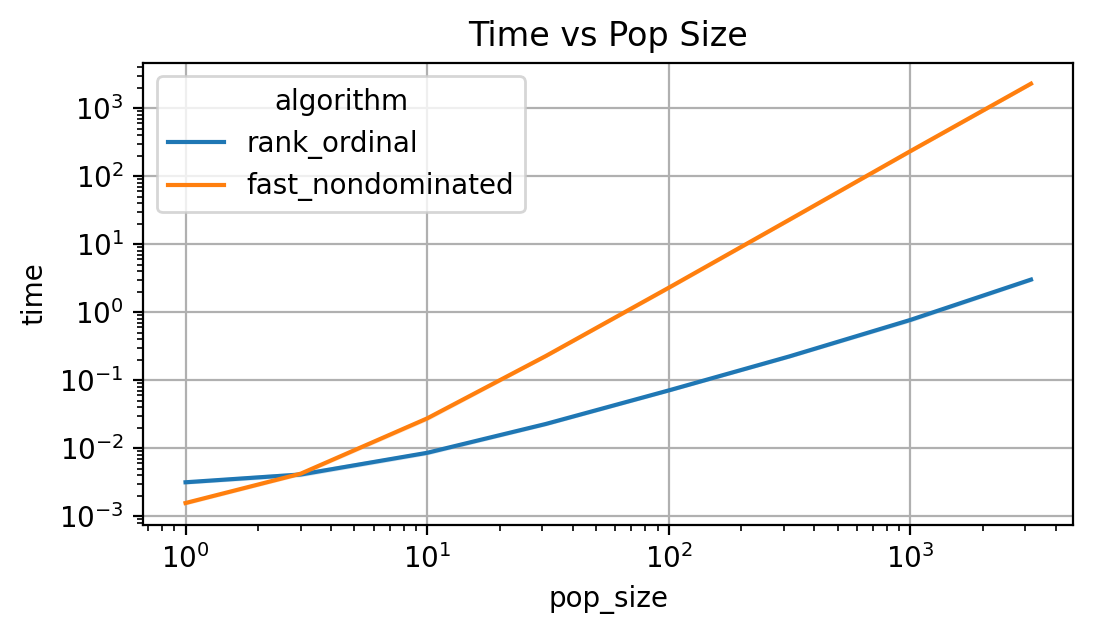

In [9]:
fig, ax = plt.subplots()
sns.lineplot(bench_df, x="pop_size", y="time", hue="algorithm", ax=ax)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Time vs Pop Size")
ax.grid()